In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install fasttext-langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.3-py3-none-any.whl (222 kB)
  Created wheel for fasttext-langdetect: filename=fasttext_langdetect-1.0.5-py3-none-any.whl size=7522 sha256=b7e8c7cc110e3123b499073ebd4e22599fe2d43ca768e8c12fddcacf95845dab
  Stored in directory: /root/.cache/pip/wheels/ba/0c/91/bd32e760105a77b98238686ace395c1e8cc1602b4b1e2be852
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-linux_x86_64.whl size=4399751 sha256=22191b0228e49656fbf322ef0b7a4bbaa662aec09884651d82d0d327722164b0
  Stored in directory: /root/.cache/pip/wheels/93/61/2a/c54711a91c418ba06ba195b1d78ff24fcaad8592f2a694ac94
Successfully built fasttext-langdetect fasttext


In [ ]:
import pandas as pd
import numpy as np
import re

from ftlangdetect import detect

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import spacy
nlp=spacy.load("en_core_web_sm")

import os 
from nltk import ngrams
from collections import Counter
import tqdm

import nltk 
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
#Using zipfile to extract JSON files from the .zip file
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/pdf_json.zip", 'r')
zip_ref.extractall("/content/files/")
zip_ref.close()

In [ ]:
#Function to extract the text from the JSON files
import json
def extract_body_text(filename):
  file1 = open(filename)
  paper_content = json.load(file1,encoding='utf-8')
  body_text = ""
  if "body_text" in paper_content :
    for bt in paper_content ["body_text"]:
      body_text = body_text + bt["text"]
  return ( body_text + '\n').lower()

In [ ]:
#Function for performing text preprocessing
#Preprocessing includes case folding, removing punctuations and lemmatization
def preprocessing(text):
  res=""

  #Converting corpus to lower case
  text=text.lower()

  #Removing references
  text=re.sub("\[\d+\]"," ",text)

  #Removing numbers
  text=re.sub("\d+"," ",text)

  #Removing punctuations
  text=re.sub("""\$|-|\#|\^|\(|\)|\-|#|@|\'|\+|\"|\/|\.|\,|\;|\:|\%|\=|\*"""," ",text)

  #Removing multiple occurences of space with a single space
  text=re.sub("\s*\s"," ",text)
  
  return text


<b>Building the corpus from the JSON files and forming the bigrams and trigrams</b>

In [ ]:
#Stopwords
stop_words = set(stopwords.words('english'))

#Lemmatizer object  
lm = WordNetLemmatizer()

In [ ]:
s="i went to the doctor's place"
doc=nlp(s)
for token in doc:
  if not token.is_stop and token.text!="":
    print(token.lemma_)

go
doctor
place


In [ ]:
#Counter object to store the frequency of words appearing in the corpus
freq_words=Counter()

for j in tqdm.tqdm(os.listdir("files/pdf_json/")):
    try:
      text=preprocessing(extract_body_text(f'files/pdf_json/{j}'))

      #Detecting the language of the text
      lang=detect(text,low_memory=False)

      if lang["lang"]=="en":

        words=text.split(" ")

        #Lemmatizing the text and removing stopwords
        #Using Lemmatizer from NLTK instead of spaCy(which works better and lemmatizes tokens according to their pos tags automatically) because spaCy is taking too much time
        words=[lm.lemmatize(i) for i in words if i!='' and i not in stop_words]


        #Updating the counter object
        freq_words.update(words)

    except UnicodeDecodeError:
      pass

100%|██████████| 56529/56529 [21:11<00:00, 44.46it/s]


In [ ]:
#To store the vocabulary
vocab=[]

#Setting vocab limit to 20000
lim=20000

for word in freq_words.keys():

  #Taking words that appear atleast 20 times in the corpus
  if freq_words[word]>20 and len(vocab)<lim:
    vocab.append(word)

In [ ]:
#To store the left-to-right co-occurence matrix
mat=np.zeros((len(vocab),len(vocab)))

#To store the right-to-left co-occurence matrix
mat_rev=np.zeros((len(vocab),len(vocab)))

In [ ]:
#To store the index of words from vocabulary
vocab_idx=dict()
for i in range(len(vocab)):
  vocab_idx[vocab[i]]=i

In [ ]:
#To store the words corresponding to the indexes in vocab_idx
idx_vocab=dict()
for i,j in vocab_idx.items():
  idx_vocab[j]=i

In [ ]:
for j in tqdm.tqdm(os.listdir("files/pdf_json/")):
    try:
      text=preprocessing(extract_body_text(f'files/pdf_json/{j}'))

      lang=detect(text,low_memory=False)

      if lang["lang"]=="en":
        words=text.split(" ")

        words=[lm.lemmatize(i) for i in words if i!='' and i not in stop_words]


        #Using a window size of 10 to build the matrix
        grams11=ngrams(words,11)

        #Storing the weights of co-occurence words in the window
        ramp = [0, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
        for index, grams in enumerate(grams11):

          #To store the right-to-left ngrams
          reversed_grams = grams[::-1]

          if not None in grams:

            for idx, gram in enumerate(grams):
            

              #Updating the left-to-right matrix
              mat[vocab_idx[grams[0]],vocab_idx[grams[idx]]] += ramp[idx]

            for idx, gram in enumerate(reversed_grams):
              try:

                #Updating the right-to-left matrix
                mat_rev[vocab_idx[reversed_grams[0]],vocab_idx[reversed_grams[idx]]] += ramp[idx]
              except:
                pass
    except:
      pass

100%|██████████| 56529/56529 [21:17<00:00, 44.24it/s]


In [ ]:
#Matrices to store the normalized vectors
#mat_1=[None for i in range(20000)]
#mat_1_rev=[None for i in range(20000)]

mat_1=np.zeros((len(vocab),len(vocab)))
mat_1_rev=np.zeros((len(vocab),len(vocab)))


for i in range(len(mat)): 
  if sum(mat[i])==0:

    #Replacing the zero occuring vectors with large values to avoid miscalculations of euclidean distances
    mat_1[i]=[10**10 for i in range(len(mat[i]))]
  else:

    #Normalizing the vectors
    mat_1[i]=mat[i]/np.linalg.norm(mat[i])

for i in range(len(mat_rev)): 

  if sum(mat_rev[i])==0:

    mat_1_rev[i]=[10**10 for i in range(len(mat_rev[i]))]

  else:
    
    mat_1_rev[i]=mat_rev[i]/np.linalg.norm(mat_rev[i])

In [ ]:
#Using TSNE model to visually plot the word vectors and their similar words
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

In [ ]:
def plot_similar_words(word):
  
  #To store the index of the word
  idx=vocab_idx[word]

  #To store the vector representation of the word: the rows of the co-occurence matrices
  vec=np.append(mat_1[idx,:],mat_1_rev[idx,:])

  #To store the most similar words
  res=[]
  for i in range(len(mat_1)):

    #Verifying the word is in vocab
    if idx_vocab[i] in vocab:

    #calculating the euclidean distances between the given word and othe words
      res.append((idx_vocab[i],np.linalg.norm(vec-np.append(mat_1[i,:],mat_1_rev[i,:]))))


  res.sort(key=lambda f:f[1])

  #Storing the words for plotting
  labels=[word]

  #Storing the vectors
  tokens=[mat_1[vocab_idx[word]]]

  #Finding the nearest 40 words
  for i in range(40):
    labels.append(res[i][0])
    tokens.append(mat_1[vocab_idx[res[i][0]]])

  tokens=np.array(tokens)

  #Fitting the model to find the nearest words
  new_values = tsne_model.fit_transform(tokens)

  x = []
  y = []
  for value in new_values:
    x.append(value[0])
    y.append(value[1])
          
  plt.figure(figsize=(8,8)) 
  for i in range(len(x)):

    #plotting the words and the nearest neighbours
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                      xy=(x[i], y[i]),
                      xytext=(5, 2),
                      textcoords='offset points',
                      ha='right',
                      va='bottom')
  plt.show()

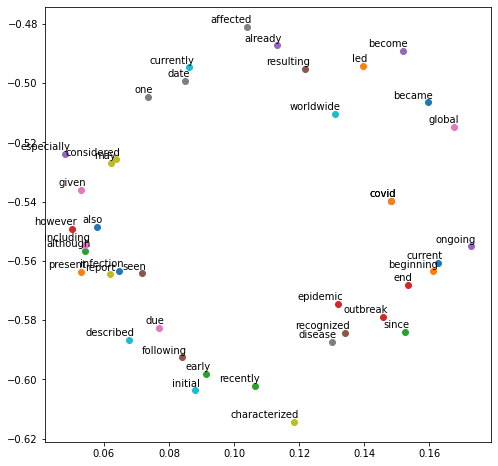

In [ ]:
plot_similar_words("covid")

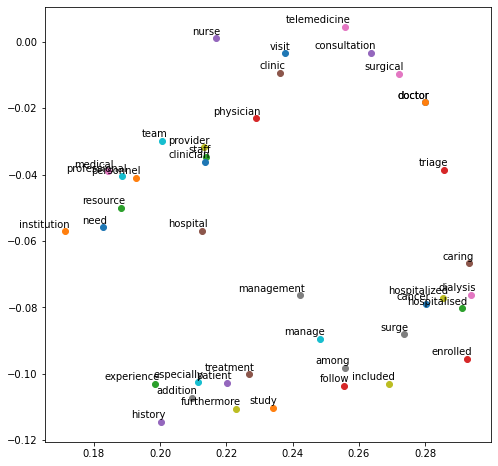

In [ ]:
plot_similar_words("doctor")

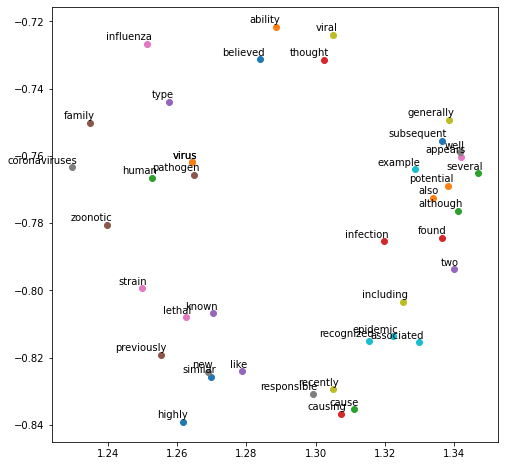

In [ ]:
plot_similar_words("virus")

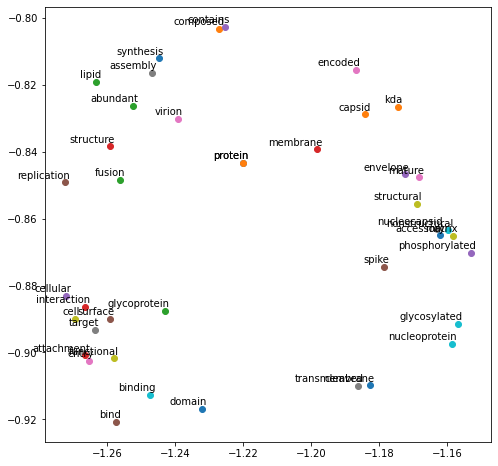

In [ ]:
plot_similar_words("protein")